## Load dataset from Kaggle

###Sketch2Code
Transform any hand-drawn design into a HTML code with Deep Learning.

https://www.kaggle.com/datasets/vshantam/sketch2code

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/MAEBD/configs/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vshantam/sketch2code
! unzip -n sketch2code.zip
! rm sketch2code.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 331M/341M [00:02<00:00, 133MB/s]
100% 341M/341M [00:02<00:00, 140MB/s]
Archive:  sketch2code.zip


Generate dataset metadata file

https://huggingface.co/docs/datasets/image_dataset


In [ ]:
import glob
import json

data_path = "data/"
dir_path = f'{data_path}*.gui'

files = [path[5:-3] for path in glob.glob(dir_path)]

with open(f"{data_path}metadata.jsonl", "w") as outfile:

  for path in files:

    with open(f"{data_path}{path}gui") as f:
      data = f.read()
      clean_data=data.replace('\n', ' ')
      # Data to be written
      dictionary ={
        "file_name" : path + "png",
        "text" : clean_data }

      json.dump(dictionary, outfile)

      outfile.write("\n")

In [ ]:
! tail  data/metadata.jsonl
! zip data.zip data/*.png data/*.jsonl


{"file_name": "54E70661-82B0-4BCC-BABA-502A692D1379.png", "text": "header { btn-inactive, btn-inactive, btn-inactive } row { quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } } row { single { small-title, text, btn-orange } } row { double { small-title, text, btn-orange } double { small-title, text, btn-orange } } "}
{"file_name": "CDD5ABA6-F931-4CE9-966F-8C51EC34581B.png", "text": "header { btn-inactive, btn-inactive, btn-inactive } row { quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } } row { quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } quadruple { small-title, text, btn-orange } } row { double { small-title, text, btn-orange } double { small-title,

In [ ]:
! pip install datasets

Resolving data files:   0%|          | 0/3399 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1699 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

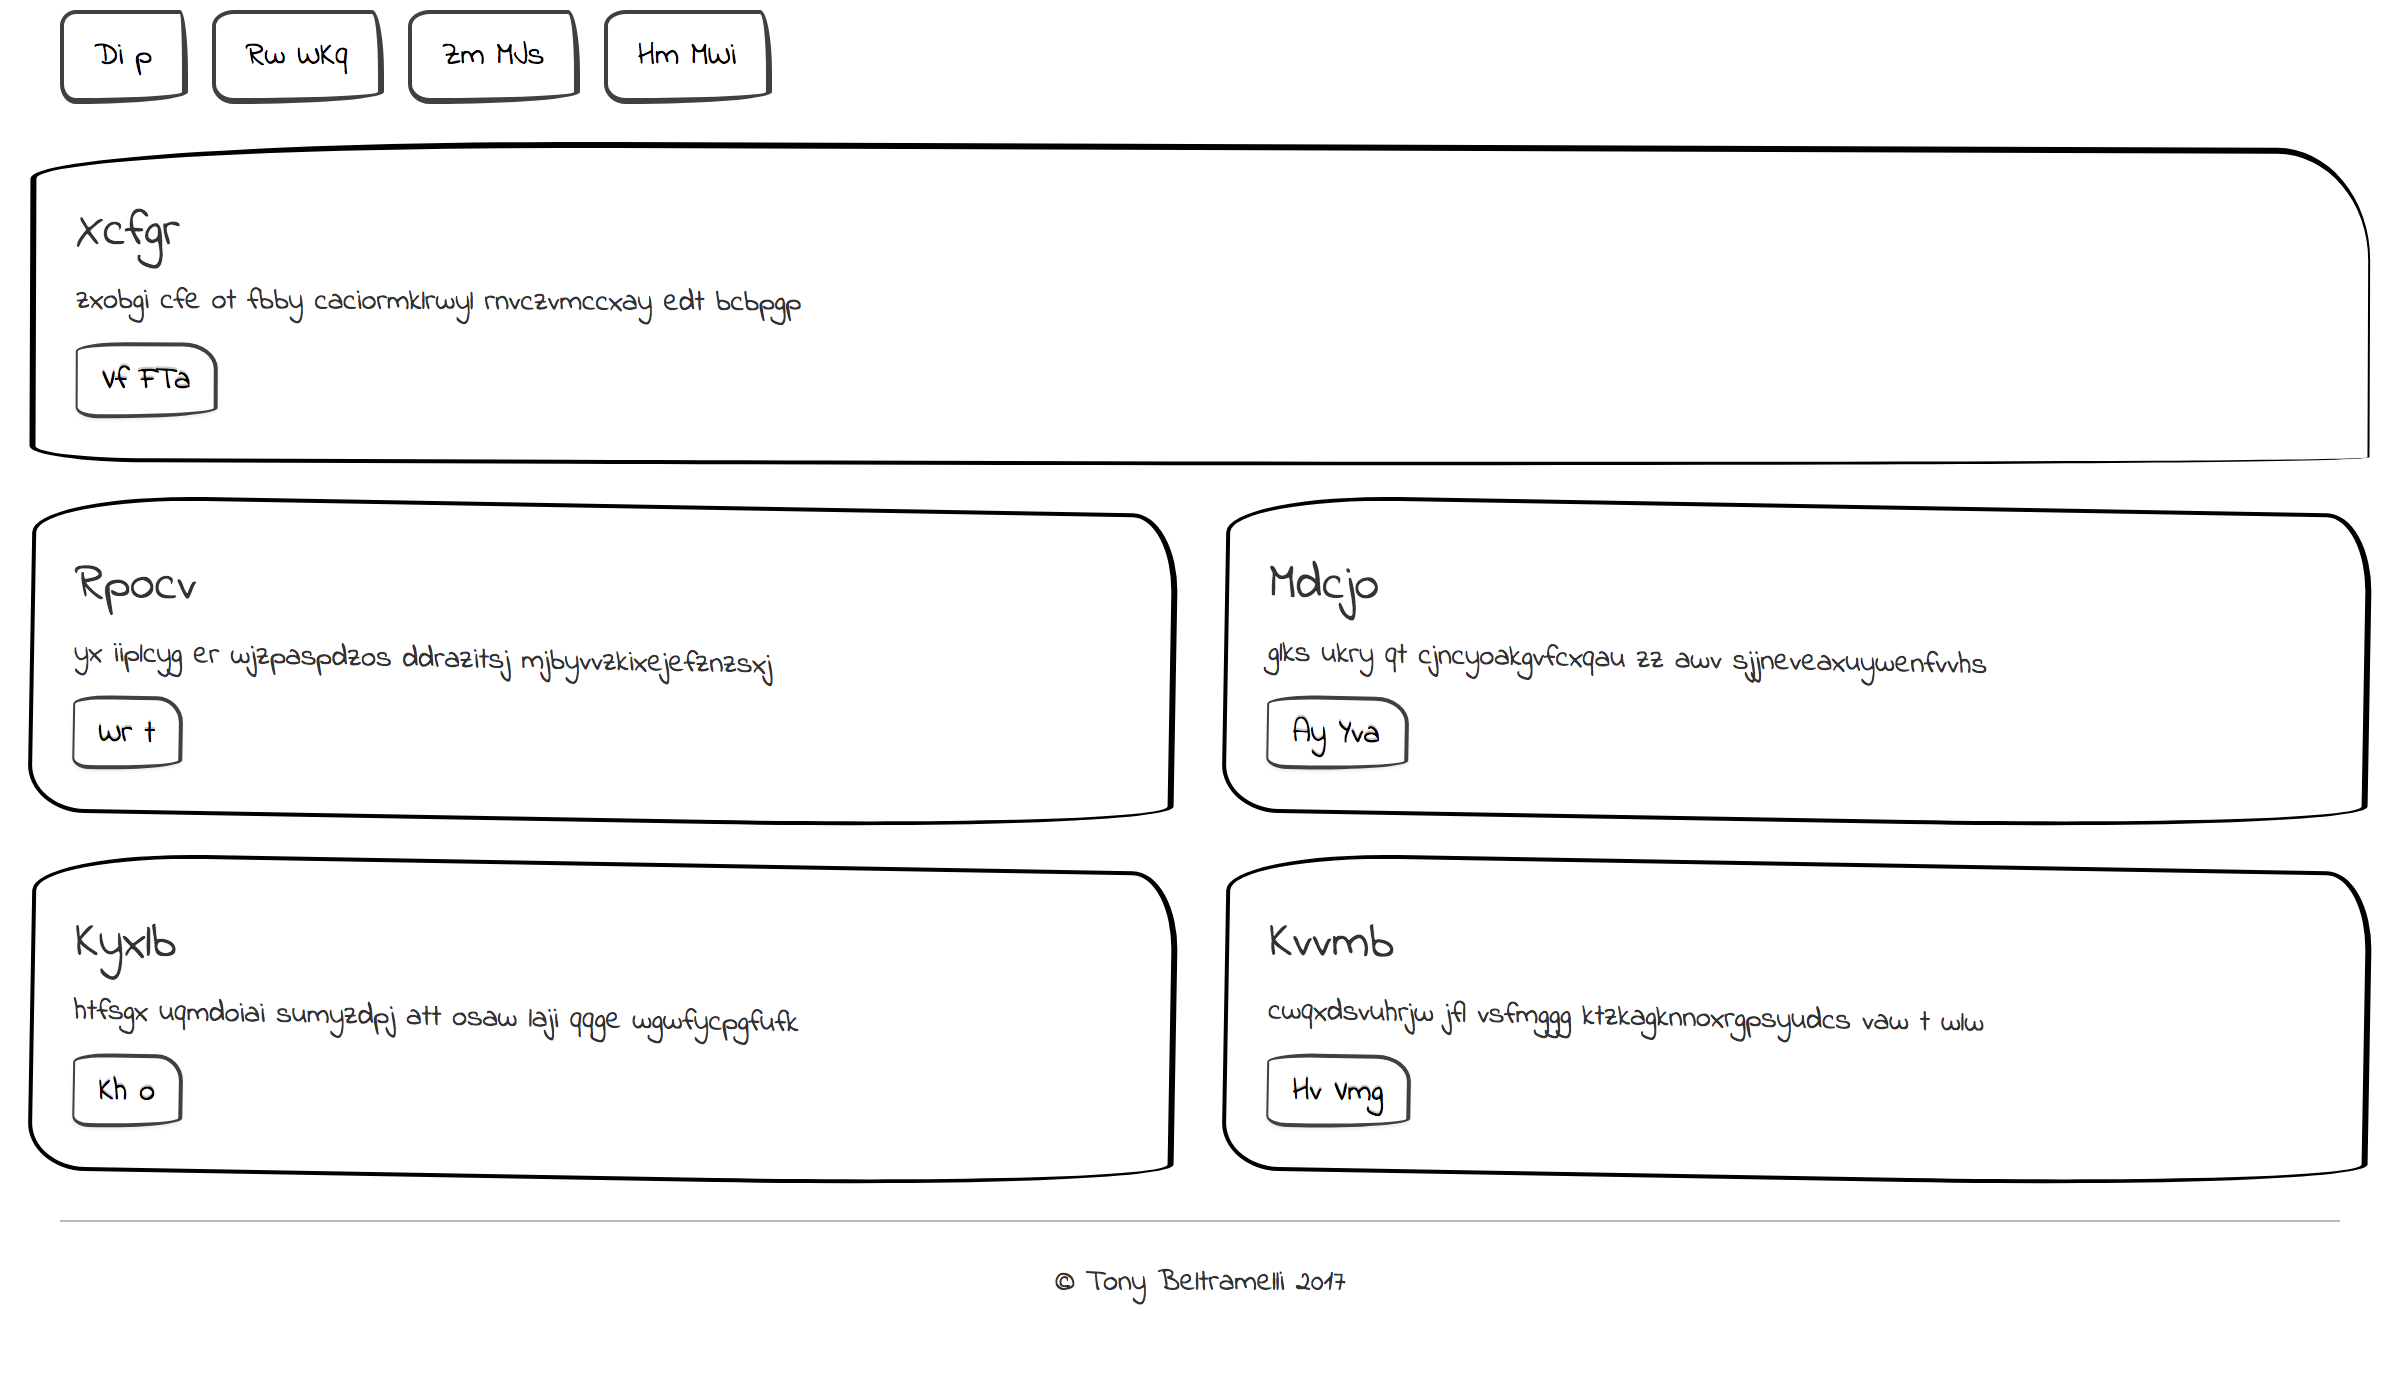

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="data", split="train")

dataset[0]["image"]

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1699
})

In [ ]:
! pip install transformers

##Create PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"].convert("RGB").resize((200,200)), return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding


In [ ]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("ybelkada/pix2struct-base")

In [ ]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  texts = [item["text"] for item in batch]

  text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=400)

  new_batch["labels"] = text_inputs.input_ids

  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])

  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, collate_fn=collator)

In [ ]:
train_dataset.dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1699
})

In [ ]:
import torch

EPOCHS = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(EPOCHS):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    labels = batch.pop("labels").to(device)
    flattened_patches = batch.pop("flattened_patches").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(flattened_patches=flattened_patches,
                    attention_mask=attention_mask,
                    labels=labels)

    loss = outputs.loss

    print(("Epoch:", epoch, "Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 31.90936851501465
Loss: 29.27692985534668
Loss: 30.43538475036621
Loss: 28.260377883911133
Loss: 28.690881729125977
Loss: 27.779020309448242
Loss: 27.878210067749023
Loss: 26.44662094116211
Loss: 26.110652923583984
Loss: 30.573936462402344
Loss: 25.743221282958984
Loss: 26.87959861755371
Loss: 25.089618682861328
Loss: 24.73512077331543
Loss: 33.18198776245117
Loss: 26.93227195739746
Loss: 24.99945068359375
Loss: 22.807283401489258
Loss: 22.65213966369629
Loss: 23.005334854125977
Loss: 27.38565444946289
Loss: 23.7831974029541
Loss: 22.608165740966797
Loss: 23.306840896606445
Loss: 22.788923263549805
Loss: 27.503643035888672
Loss: 21.290424346923828
Loss: 20.756227493286133
Loss: 20.33088493347168
Loss: 21.054874420166016
Loss: 27.542043685913086
Loss: 30.539867401123047
Loss: 20.74146842956543
Loss: 24.897876739501953
Loss: 19.068889617919922
Loss: 24.709014892578125
Loss: 20.295982360839844
Loss: 28.750442504882812
Loss: 18.591890335083008
Loss: 21.411113739013672
Loss: 

In [ ]:
model.eval()

predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)
print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))